# Case 2: Cargo Ship
The ship MS Leiden is traveling on a route involving five harbors in north-
ern Europe: Rotterdam, Hamburg, Kiel, Aarhus, and Copenhagen. You have
been asked to help the Captain with the loading and unloading plan (for the
destination harbors) that produces

- even and well-balanced solution
- a solution that is easy to unload (so that containers that are earlier un-loaded are not beneath containers that are later unloaded)
- solutions that can integrate as many containers as possible

The following details about the problem are provided:
1. The ship is now docked in Rotterdam. After visiting Rotterdam, the ship
will be traveling to Hamburg, Aarhus, and Copenhagen, in that order. The
containers destined for Rotterdam have been unloaded and the containers
destined for the remaining three harbors have to be loaded on the ship.
2. MS Leiden is a rather small container ship. It has eight bays, three tiers
and four rows. The layout of the ship is shown in the figure below.
3. Containers should be loaded such that a container that has to be unloaded
earlier should be placed in a higher position.
4. Each cell in the above figure is able to hold a forty-foot container. That
is, the ship has room for 8 × 3 × 4 = 96 forty-foot containers.
5. A forty-foot container can be placed on-top of another forty-foot container,
but not on top of an empty cell. We assume that only forty-foot containers
are loaded on the ship. Each container has a destination port.
6. Each container $i$ has a certain weight $w_i$. If a container is much heavier
than another $i$ container $j$, say $w_i − w_j > δ_w$, then it is not allowed to
place $w_i$ on top of $w_j$ .
7. The containers should be balanced in a way that is evenly distributed. The
longitudinal center of gravity should be as close as possible to the middle
of the container section of the ship. Secondly, the latitudinal center of
gravity should be as much to the middle as possible. Note that the center
of gravity can be computed as the weighted sum of the centroids of the
containers, where the weights are the total weight of the containers.

![title](cargo3.png)

In [2]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import Problem
from pymoo.problems.functional import FunctionalProblem
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.optimize import minimize
from pymoo.indicators.hv import Hypervolume
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions

import numpy as np
import matplotlib.pyplot as plt

## Code

Balance score can be calculated as:
The containers should be balanced in a way that is evenly distributed. The
longitudinal center of gravity should be as close as possible to the middle
of the container section of the ship. Secondly, the latitudinal center of
gravity should be as much to the middle as possible. Note that the center
of gravity can be computed as the weighted sum of the centroids of the
containers, where the weights are the total weight of the containers.

In [3]:
# Create DATA
def create_data(n=50):

    global DATA, HARBORS

    h = np.random.randint(1, 4, n)
    w = np.random.randint(2000, 40000, n)

    DATA = np.array(list(zip(h,w)))

    HARBORS = np.unique(DATA[:,0])

### Helper functions

In [4]:
def remove_harbor_containers(configuration, destination):
    # Example of removing container 1 from a single stack: 
    # [2,1,2] -> remove number -> [2,2] -> add to length of 3 -> [2,2,0]
    for bay in range(configuration.shape[0]):
        for row in range(configuration.shape[2]):
            stack = configuration[bay, :, row, :]
            if destination in stack[:,0]:
                stack = stack[stack[:,0] != destination]
                stack = np.append(stack, np.zeros((3-len(stack),2)), axis=0)
                configuration[bay, :, row, :] = stack
    return configuration

def positions_to_matrix(positions):

    configuration = np.zeros((8,3,4,2), dtype=int)

    for i, position in enumerate(positions):

        layer = int(position // 32)
        position = position % 32
        bay = int(position // 4)
        row = int(position % 4)
        
        configuration[bay, layer, row, :] = DATA[i]

    return configuration

def create_population(pop_size):

    sorted_data = np.flip(DATA[:, 1].argsort(), axis=0)

    population = []
    for _ in range(pop_size):

        individual = np.zeros(len(DATA))
        for idx in sorted_data:

            while True:

                rand_position = np.random.randint(1, 33)

                positions = set(np.arange(rand_position, 97, 32)) - set(individual)

                if len(positions) > 0: 
                    individual[idx] = min(positions)
                    break
        
        population.append(individual-1)

    return np.array(population, dtype=int)

### Objective 1: Stability

In [5]:
def sum_tiers(configuration):

    only_weights = configuration[:, :, :, 1]
    summed_configuration = np.sum(only_weights, axis=1)

    return summed_configuration

def get_longitudinal_center(summed_configuration):

    weights = np.sum(summed_configuration, axis=1)
    positions = np.arange(1, 9)

    sum_weights = np.sum(weights)
    if sum_weights != 0:
        return np.sum(weights * positions) / sum_weights
    else:
        return 1 # Worst stability value possible together with 8

def get_lattitudinal_center(summed_configuration):

    weights = np.sum(summed_configuration, axis=0)
    positions = np.arange(1, 5)

    sum_weights = np.sum(weights)
    if sum_weights != 0:
        return np.sum(weights * positions) / sum_weights
    else:
        return 1 # Worst stability value possible together with 4

def calculate_centers(configuration):

    summed_configuration = sum_tiers(configuration)

    longitudinal_center = get_longitudinal_center(summed_configuration)
    lattitudinal_center = get_lattitudinal_center(summed_configuration)

    return longitudinal_center, lattitudinal_center

def get_score(configuration):

    longitudinal_center, lattitudinal_center = calculate_centers(configuration)

    long_error, latt_error = abs(longitudinal_center - 4.5), abs(lattitudinal_center - 2.5)

    return long_error + latt_error

# def calculate_total_stability(candidate_solutions):

#     stability_scores = []

#     for candidate in candidate_solutions:

#         configuration = positions_to_matrix(candidate)

#         stability_score = 0
#         for i in HARBORS:
#             stability_score += get_score(configuration)
            
#             if i < 3:
#                 configuration = remove_harbor_containers(configuration, i)
        
#         stability_scores.append(stability_score)
#     print('Stability scores:',stability_scores)
#     return np.array(stability_scores)

def calculate_total_stability(candidate):

    configuration = positions_to_matrix(candidate)

    stability_score = 0
    for i in HARBORS:
        stability_score += get_score(configuration)
        
        if i < 3:
            configuration = remove_harbor_containers(configuration, i)
    
    return stability_score

### Objective 2: Unloading time

In [6]:
# def get_unloading_time(candidate_solutions):

#     unloading_times = []
    
#     for candidate in candidate_solutions:

#         configuration = positions_to_matrix(candidate)
#         only_harbors = configuration[:, :, :, 0]

#         unloading_time = 0
#         for i in range(8):
#             for j in range(4):
#                 stack = only_harbors[i, :, j]
#                 stack = stack[stack != 0]
#                 if len(stack) > 1:
#                     if tuple(stack) == (2,1,3):
#                         return 4
#                     for layer in range(len(stack)-1):
#                         if stack[layer] == 1:
#                             if stack[layer+1] != 1:
#                                 unloading_time += 2
#                             if len(stack[layer:]) > 2:
#                                 if stack[layer+2] != 1 and stack[layer+1] != 1:
#                                     unloading_time += 2
#                         elif stack[layer] == 2:
#                             if stack[layer+1] == 3:
#                                 unloading_time += 2
#                             if len(stack[layer:]) > 2:
#                                 if stack[layer+2] == 3 and stack[layer+1] == 3:
#                                     unloading_time += 2
#         unloading_times.append(unloading_time/n)
#     print('Unloading times:',unloading_times)
#     return unloading_times


def get_unloading_time(candidate):

    configuration = positions_to_matrix(candidate)
    only_harbors = configuration[:, :, :, 0]

    unloading_time = 0
    for i in range(8):
        for j in range(4):
            stack = only_harbors[i, :, j]
            stack = stack[stack != 0]
            if len(stack) > 1:
                if tuple(stack) == (2,1,3):
                    return 4
                for layer in range(len(stack)-1):
                    if stack[layer] == 1:
                        if stack[layer+1] != 1:
                            unloading_time += 2
                        if len(stack[layer:]) > 2:
                            if stack[layer+2] != 1 and stack[layer+1] != 1:
                                unloading_time += 2
                    elif stack[layer] == 2:
                        if stack[layer+1] == 3:
                            unloading_time += 2
                        if len(stack[layer:]) > 2:
                            if stack[layer+2] == 3 and stack[layer+1] == 3:
                                unloading_time += 2

    return unloading_time/n_var

### Problem Initialization

In [7]:
create_data()

n_var = len(DATA)

def overlapping_eval(candidate):

    candidate = [int(pos) for pos in candidate]
    
    if n_var != len(set(candidate)):
        return -1 * (n_var - len(set(candidate)))
    else:
        return 0

def levitating_eval(candidate):

    candidate = [int(pos) for pos in candidate]
    
    breachness = 0

    for pos in candidate:

        if pos < 32:
            continue
        else:
            # pos_below = np.arange(pos-32, -1, -32)
            pos_below = pos - 32
            if not pos_below in candidate:
                # print('We have:',pos,' but we dont have:', pos_below)
                breachness -= 1

    return breachness

def weight_eval(candidate):

    delta_weight = 2000

    candidate = [int(pos) for pos in candidate]

    pos_weights = list(zip(candidate, DATA[:,1]))
    breachness = 0
    for pos, weight in pos_weights:
        if pos < 32:
            continue
        else:
            pos_below = pos - 32
            try:
                weight_below = pos_weights[candidate.index(pos_below)][1]
                if weight > weight_below + delta_weight:
                    breachness += weight_below + delta_weight - weight
            except:
                continue

    return breachness


objectives = [
    calculate_total_stability,
    get_unloading_time
]

constraints_eq = [
    overlapping_eval,
    levitating_eval,
    weight_eval
]

problem = FunctionalProblem(len(DATA),
                            objectives,
                            constr_eq=constraints_eq,
                            xl=np.array([0] * len(DATA), dtype=int),
                            xu=np.array([95] * len(DATA), dtype=int)
                            )

solutions = create_population(1)

F, G = problem.evaluate(solutions)

print(f"F: {F}\n")
print(f"G: {G}\n")

F: [[2.39160151 0.4       ]]

G: [[0. 0. 0.]]



In [8]:
pop_size = 100
initial_population = create_population(pop_size)

ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=12)

method = NSGA3(pop_size=pop_size,
            sampling=IntegerRandomSampling(),
            crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
            mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
            eliminate_duplicates=True,
            ref_dirs=ref_dirs
            )

In [9]:
res = minimize(problem,
               method,
               termination=('n_gen', 1000),
               seed=1,
               save_history=True
               )

KeyboardInterrupt: 

### Found solutions

In [56]:
X, F, C = res.opt.get("X", "F", "feasible")

hist = res.history

print('-------------- FOUND SOLUTIONS --------------\n')
for x, f, c in zip(X, F, C):
    print('Container positions:',x)
    print('Stability:',str(round(f[0],3))+'    Unloading time',f[1])
    if c[0]:
        print('Solution is feasible\n')
    else:
        print('Solution is infeasible...\n')
print('---------------------------------------------')


-------------- FOUND SOLUTIONS --------------

Container positions: [12  6 15 37 51  8 13 60 24 14 21  5 47 19  1 28 32  9 20  2 36 56 44 67
 26 11 55 76 31 59 17 18 45 93  3 40 53 27  7 23  4 22 61 35 30 87  0 25
 29 49]
Stability: 0.045    Unloading time 0.04
Solution is feasible

Container positions: [12  6 15 37 51  8 13 60 24 14 21  5 46 19  1 28 33  9 20  2 36 56 44 67
 26 11 55 77 31 63 17 18 45 93  3 40 53 27  7 23  4 22 61 35 57 88  0 25
 29 50]
Stability: 0.021    Unloading time 0.16
Solution is feasible

Container positions: [12  6 15 37 49  8 13 60 24 14 21  5 33 19  1 28 16  9 20  2 40 57 44 76
 26 11 55 85 31 59 17 18 46 93  3 41 53 27  7 23 39 22 61 35 52 71  0 25
 29 50]
Stability: 0.084    Unloading time 0.0
Solution is feasible

---------------------------------------------


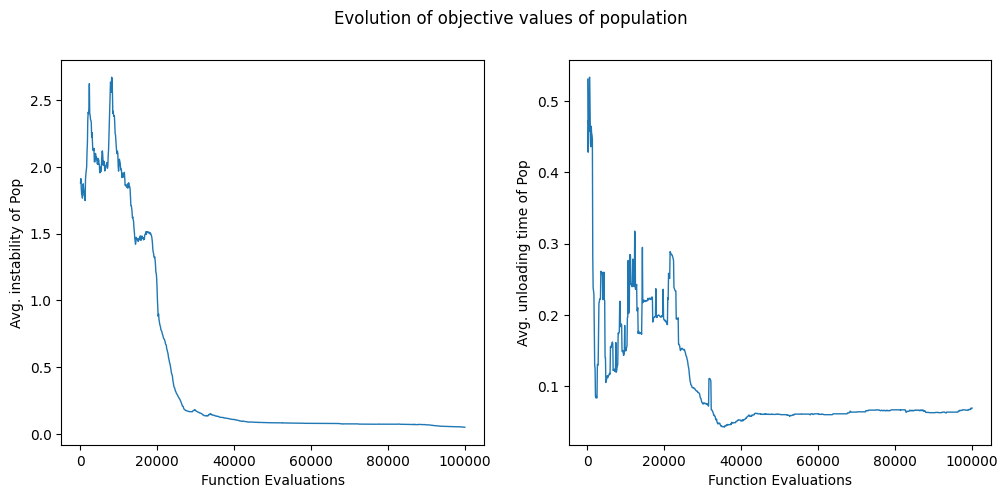

In [47]:
n_evals = []

hist_stability_avg = []
hist_unloading_avg = []

boat_history = []

approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)

for i, algo in enumerate(hist):

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    hist_stability_avg.append(algo.pop.get("F")[:,0].mean())
    hist_unloading_avg.append(algo.pop.get("F")[:,1].mean())

    # retrieve the optimum from the algorithm
    opt = algo.opt

    if i % 50 == 0:

        boat_matrix = positions_to_matrix(opt.get("X")[0])

        boat_history.append(boat_matrix)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax[0].plot(n_evals, hist_stability_avg, lw=1, label="Avg. stability of Pop")
ax[0].set_ylabel('Avg. instability of Pop')
ax[0].set_xlabel('Function Evaluations')
ax[1].plot(n_evals, hist_unloading_avg,  lw=1, label="Avg. unloading time of pop")
ax[1].set_ylabel('Avg. unloading time of Pop')
ax[1].set_xlabel('Function Evaluations')
fig.suptitle("Evolution of objective values of population")
plt.show()

In [10]:
pareto_front = []
for _ in range(10):

    res = minimize(problem,
                method,
                termination=('n_gen', 1000),
                seed=1,
                save_history=True
                )
    
    F = res.opt.get("F")

    pareto_front.extend(F)

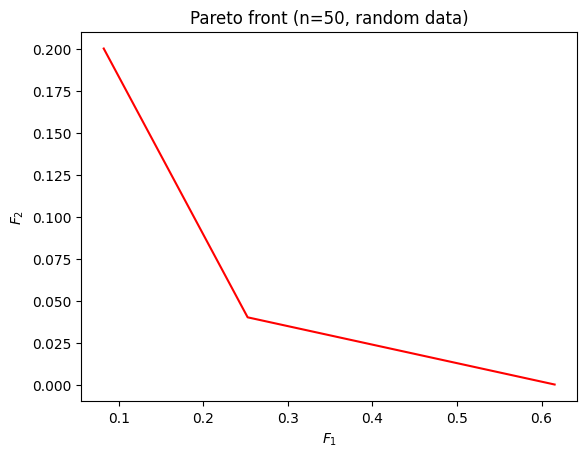

In [43]:
pareto_front_arr = np.array(pareto_front)

pareto_points = np.array(list(set(tuple(i) for i in pareto_front_arr)))

plt.plot(pareto_points[:,0], pareto_points[:,1], color='red')
plt.xlabel('$F_1$')
plt.ylabel('$F_2$')
plt.title('Pareto front (n=50, random data)')
plt.show()

### Backup history of configuration

In [48]:
boat_history = np.array(boat_history)

np.save(f'Results/boat_history_n={len(DATA)}.npy', boat_history)